# Working with Text Data - NLP BASICS

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Deep Learning for text and sequences

Applications of these algorithms includes:
- Document Classification and time series classification, such as identifying the topic of an article or the author of the book.
- Timeseries comparisons, such as estimating how closely related two documents or two stock tickers are,
- Sequence to sequence learning, such as decoding an English sentence to French,
- Sentiment analysis, such as classifying the sentiment of tweets or movie reviews as positive or negative,
- Timeseries forecasting, such as predicting the future weather at a certain location, given recent weather data.

### Working with text data

Like all other neural networks, deep learning models don't take as input raw text:
- They only work with numeric tensors.
- Vectorizing text is the process of transforming text into numeric tensors.
- This can be done in multiple ways:
    - Segment text into words, and transform each word into a vector
    - Segment text into characters, and transforms each character into a vector.
    - Extract n-grams of words or characters, and transform each n-gram into a vector.
    - N-grams are overlapping groups of multiple consecutive words or characters.

Different units into which we can break down text(words, characters, or n-grams) are called **tokens** and the process is called **tokenization**.<br><br>

Ways to associate a vector with a token:
- One hot encoding
- Token embedding(word embedding)

### Word level one-hot encoding

In [2]:
import numpy as np

samples = ['The cat sat on the mat.', 'The dog ate my homwork.']    # Initial data: one entry per sample(In this example, a sample is a sentence, but it could be an entire document)

token_index = {}                                                    # Builds an index of all tokens in the data
for sample in samples:
    for word in sample.split():                                     # Tokenizes the samples via the split method. In real life, you'd also strip punctuation and special characters fromt he samples.
        if word not in token_index:
            token_index[word] = len(token_index) + 1                # Assigns a unique index to each unique word. Note that you don't attributr index o to anything.
            
max_length = 10                                                     # Vectorizes the samples, You'll only consider the first max_length words in each sample.

results = np.zeros(shape=(len(samples),
                          max_length,
                          max(token_index.values()) + 1))           # This is where you store the results.

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1 

### Character level one-hot encoding

In [3]:
import string

samples = ['The cat sat on the mat.', 'The dog ate my homwork.']
characters = string.printable                                               # All printable ASCII characters
token_index = dict(zip(range(1, len(characters) + 1), characters))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.keys()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)
        results[i, j, index] = 1

### Using Keras for word-level one hot encoding

In [4]:
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homwork.']

tokenizer = Tokenizer(num_words=1000)                                  # Creates a tokenizer, configured to only take into account the 1000 ost common words.
tokenizer.fit_on_texts(samples)                                        # Builds the word index

sequences = tokenizer.texts_to_sequences(samples)                      # Turns strings into lists of integer indices

one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')    # You could also directly et the one-hot binary representation. Vectorization modes other than one-hot encoding are supported by this tokenizer

word_index = tokenizer.word_index                                      # How you can recover the word index that was computed
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 9 unique tokens.


### Word level one-hot encoding with hashing trick

In [5]:
samples = ['The cat sat on the mat.', 'The dog ate my homwork.']

dimensionality = 1000                                              # Stores the words as vectors of size 1000. If you have close to 1000 words(or more), you'll see many hash collisions, which will decrease the accuracy of this encoding method.
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality                   # Hashes the word into a random integer index between 0 and 1000
        results[i, j, index] = 1

### Using word embeddings

| Vectors obtained through OHE| Vectors obtained using word embeddings|
| ------------- | -------------------|
| Binary and sparse(almost made of zero) | dense word vectors|
| Very high dimensionality | low dimension floating-point vectors |
| Leads to vectors that are 20000 dimensional or greater | 256 dimensional, 512 dimensional, when dealing with large vocabularies |

### Learning word embedding with embedding layers

- Simplest way to associate a dense vector with a word is to choose the vector at random.
- Problem with this is that resulting embedding space has no structure.
- It's difficult for a deep neural network to make sense of such a noisy, unstructured embedding space.
- Geometric relationships between word vectors should reflect the semantic relationship between words.
- Its thus reasonable to learn, a new embedding space with every new task.
- Backpropagation makes this easy, and Keras makes it even easier.
- Its about learning the weights of a layer, the Embedding Layer.

### Instantiate an Embedding layer

In [6]:
from keras.layers import Embedding
embedding_layer = Embedding(1000, 64)  # takes at least two arguments: the number of possible tokens(here, 1000: 1 + maximum word index) and the dimensionality of the embedding(here, 64)

Word index ------------> Embedding Layer --------------> Corresponding word vector

### Loading IMDB data for use with an embedding layer

In [7]:
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000                                   # number of words to consider as features
maxlen = 20                                            # Cuts off the text after this number of words(among the max_features most common words)

(x_train, y_train), (x_test, y_test) = imdb.load_data(
    num_words=max_features)                            # Loads the data as list of integers 

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen) # Turns the lists of integers into a 2D interger tensor of shape(samples, maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

### Using an Embedding layer and classifier on the IMDB data

In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_3 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 52us/step - loss: 0.6676 - acc: 0.6182 - val_loss: 0.6167 - val_acc: 0.6928
Epoch 2/10
20000/20000 [==============================] - 1s 40us/step - loss: 0.5415 - acc: 0.7488 - val_loss: 0.5276 - val_acc: 0.7324
Epoch 3/10
20000/20000 [==============================] -

### Using pretrained word embeddings

There are various precomputed databases of word embeddings that you can download and use in Keras Embedding layer.
- Word2vec is one of them.
- Another popular one is called Global vectors fro Word Representation based on factorizing a matrix of word co-occurence statistics.

In [15]:
import os

imdb_dir = 'C:/Users/mrshu/Downloads/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='latin1')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### Tokenizing the data

- Vectorize and prepare a training and validation split.
- We will restrict the training data to the first 200 samples.

In [23]:
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100                                               # Cut off reviews after 100 words
training_samples = 200                                     # Train on 200 samples
validation_samples = 10000                                 # Validates on 10,000 samples
max_words = 10000                                          # Considers only the top 10000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])                          # Splits the data into a training set and a validation set, but first shuffles the data
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88584 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


### Parsing the GloVe word-embeddings file

In [33]:
glove_dir = 'C:/Users/mrshu/Downloads/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


### Preparing the GloVe word embedding matrix

In [35]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector           # words not found in the embedding index will be all zeros

### Model Definition

In [37]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model =  Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### Loading pretrained word embeddings into the Embedding layer

In [38]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].translate = False

### Training and Evaluation

In [39]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 1.6777 - acc: 0.5000 - val_loss: 0.7195 - val_acc: 0.5261
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.8162 - acc: 0.6150 - val_loss: 0.7149 - val_acc: 0.5214
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3258 - acc: 0.9350 - val_loss: 0.7091 - val_acc: 0.5490
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2164 - acc: 0.9450 - val_loss: 0.7670 - val_acc: 0.5248
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1633 - acc: 0.9750 - val_loss: 1.2619 - val_acc: 0.5078
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1670 - acc: 0.9600 - val_loss: 0.7680 - val_acc: 0.5356
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0516 - acc: 1.0000 - val_loss: 0.7633 - val_acc: 0.5449
Epoch 8/10
200/200 [=======

### Plotting the results

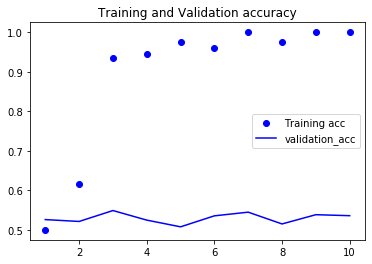

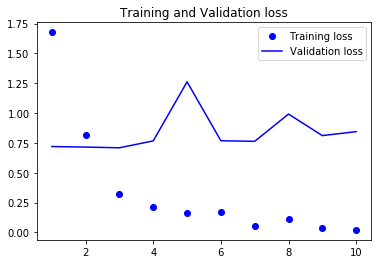

In [42]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='validation_acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

### Training the same model without pretrained word embeddings

In [45]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(x_train, y_train,
                      epochs=10,
                      batch_size=32,
                      validation_data=(x_val, y_val))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 7ms/step - loss: 0.6895 - acc: 0.4950 - val_loss: 0.6938 - val_acc: 0.5221
Epoch 2/10
200/200 [==============================] - 0s 2ms/s

### Tokenizing the data of the test set

In [49]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

### Evaluating the model on the test set

In [50]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 45us/step


[0.8547371725416183, 0.52904]

### Wrapping up

- Till now:
    - Turned raw text into something a neural networks can process.
    - Used the Embedding layer in a Keras models to learn task specific token embeddings.
    - Used pretrained word embeddings to get an extra boost on small natural language processing problems